In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('Binomial Logistic Regression').getOrCreate()
import matplotlib.pyplot as plt
import numpy as np

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

df = spark.read.csv('ksprojectsDataPreFinish.csv', header=True, inferSchema=True)
df.printSchema()
print(df.columns)


root
 |-- KsID : integer (nullable = true)
 |-- main_category: integer (nullable = true)
 |-- deadline: timestamp (nullable = true)
 |-- launched: timestamp (nullable = true)
 |-- state: integer (nullable = true)
 |-- usd_pledged_real: double (nullable = true)
 |-- usd_goal_real: double (nullable = true)
 |-- launchedYear: integer (nullable = true)
 |-- launchedMonth: integer (nullable = true)
 |-- launchedWeekday: integer (nullable = true)
 |-- campaignDur: integer (nullable = true)

['KsID ', 'main_category', 'deadline', 'launched', 'state', 'usd_pledged_real', 'usd_goal_real', 'launchedYear', 'launchedMonth', 'launchedWeekday', 'campaignDur']


In [2]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns)

,KsID,main_category,deadline,launched,state,usd_pledged_real,usd_goal_real,launchedYear,launchedMonth,launchedWeekday,campaignDur
0,1000002330,3,2015-10-09,2015-08-11,0,0.0,1533.95,2015,8,1,59
1,1000003930,1,2017-11-01,2017-09-02,0,2421.0,30000.00,2017,9,5,60
2,1000004038,1,2013-02-26,2013-01-12,0,220.0,45000.00,2013,1,5,45
3,1000007540,2,2012-04-16,2012-03-17,0,1.0,5000.00,2012,3,5,30
4,1000011046,1,2015-08-29,2015-07-04,0,1283.0,19500.00,2015,7,5,56


In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
from pyspark.ml.feature import (VectorAssembler,OneHotEncoder,StringIndexer)

In [5]:
col_now = ['main_category','usd_pledged_real','usd_goal_real','launchedYear','launchedMonth','launchedWeekday', 'campaignDur']

In [6]:
assembler = VectorAssembler(inputCols = col_now, outputCol="features")

In [7]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[assembler])

# apply it to the DataFrame.
pipeline_model = pipeline.fit(df)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(df)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('state', 'features')

In [8]:
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [9]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='state')



Training Dataset Count: 258810
Test Dataset Count: 111126


In [10]:
print("LogisticRegression parameters:\n" + lr_model.explainParams() + "\n")

LogisticRegression parameters:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: state)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPr

In [11]:
# Fit the model.
lr_model1 = lr_model.fit(train_data)

# And evaluate the model using the test data.
results = lr_model1.transform(test_data)

In [12]:
print("Model 1 was fit using parameters: ")
print(lr_model1.extractParamMap())

Model 1 was fit using parameters: 
{}


In [13]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="state", predictionCol="prediction", metricName="accuracy")

In [14]:
accuracy = evaluator.evaluate(results)

In [15]:
print ("Test set accuracy = " + str(accuracy))
print("Coefficients: " + str(lr_model1.coefficients))
print("Intercept: " + str(lr_model1.intercept))

Test set accuracy = 0.6408851213937332
Coefficients: [-5.327584359851675e-06,1.1970771702892621e-09,-1.4387224146381288e-09,4.587993876923105e-08,-2.3120274715483406e-06,-7.626614890059796e-06,-3.3396304349906343e-07]
Intercept: -0.5740327876057423


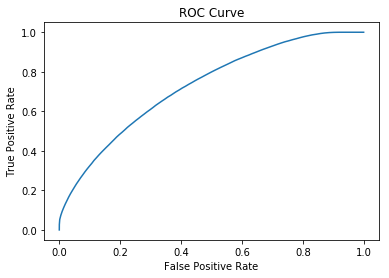

Area Under the Curve: 0.7271577400448992


In [17]:
# Let's get a summary of the data.
training_summary = lr_model1.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

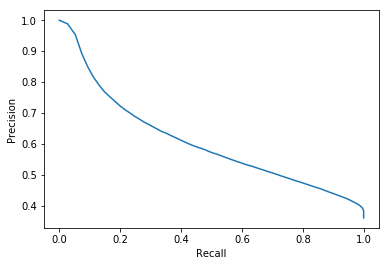

In [18]:
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Tuning the parameter of Logistic regression (2)

In [39]:
paramMap = {lr_model.maxIter: 20}

In [20]:
paramMap.update({lr_model.regParam: 0.1, lr_model.threshold: 0.55, lr_model.maxIter: 30})  # Specify multiple Params.

In [21]:
paramMap2 = {lr_model.probabilityCol: "myProbability"}  # Change output column name
paramMapCombined = paramMap.copy()
paramMapCombined.update(paramMap2)

In [22]:
lr_model2 = lr_model.fit(train_data, paramMapCombined)
print("Model 2 was fit using parameters: ")
print(lr_model2.extractParamMap())

Model 2 was fit using parameters: 
{}


In [23]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="state", predictionCol="prediction", metricName="accuracy")

In [45]:
# And evaluate the model using the test data.
results2 = lr_model2.transform(test_data)
accuracy1 = evaluator.evaluate(results2)

In [46]:
print ("Test set accuracy = " + str(accuracy1))

Test set accuracy = 0.6408851213937332


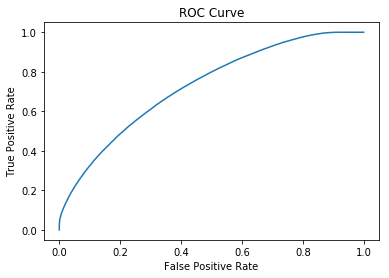

Area Under the Curve: 0.7271683679265164


In [26]:
# Let's get a summary of the data.
training_summary = lr_model2.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

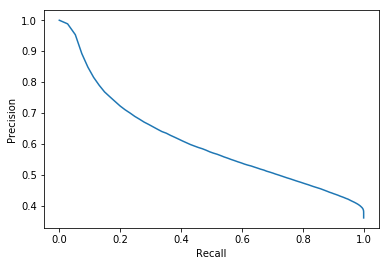

In [27]:
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Tuning the parameter of Logistic regression (3)

In [28]:
paramMap = {lr_model.maxIter: 30}

In [32]:
paramMap.update({lr_model.regParam: 0.5, lr_model.threshold: 0.65, lr_model.maxIter: 160})  # Specify multiple Params.

In [33]:
paramMap3 = {lr_model.probabilityCol: "myProbability2"}  # Change output column name
paramMapCombined = paramMap.copy()
paramMapCombined.update(paramMap3)

In [34]:
lr_model3 = lr_model.fit(train_data, paramMapCombined)
print("Model 2 was fit using parameters: ")
print(lr_model3.extractParamMap())

Model 2 was fit using parameters: 
{}


In [35]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="state", predictionCol="prediction", metricName="accuracy")

In [36]:
# And evaluate the model using the test data.
results3 = lr_model3.transform(test_data)
accuracy = evaluator.evaluate(results3)

In [37]:
print ("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.6408851213937332


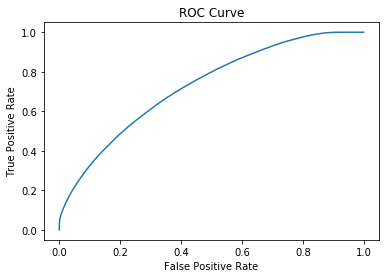

Area Under the Curve: 0.7271552148712643


In [47]:
# Let's get a summary of the data.
training_summary = lr_model3.summary

# Convert the DataFrame to a Pandas DataFrame.
ROC = training_summary.roc.toPandas()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

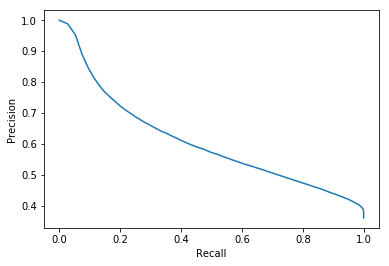

In [48]:
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()